In [4]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
import json
from pathlib import Path
from utils import create_directory
from model import test
import plot as plot
import numpy as np
import matplotlib.pyplot as plt

In [11]:
data_dir = create_directory(directory_name='try0') # loss0_if
modular = 1

0.07052246130250645


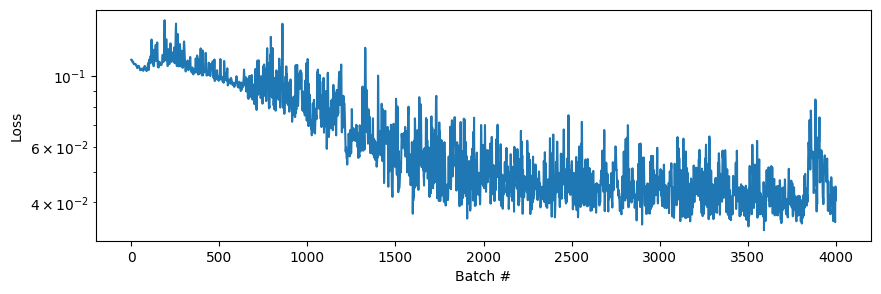

In [7]:
model_num = 0
model_name = "model{:02d}".format(model_num)

phase = 'growing_up'
log_file = list(Path(data_dir).glob(f'{model_name}_phase={phase}_*_log.json'))[0]
log = json.load(open(log_file,'r'))
fig,ax = plot.plot_training_log(log,'position',w=1)
#fig.savefig(os.path.join(data_dir,'loss_FF1.png'),dpi=300)

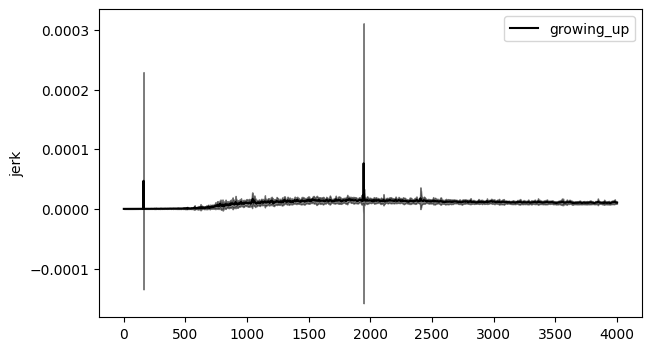

In [9]:
fig, ax = plot.plot_learning(data_dir,num_model=16,w=1,phases=['growing_up'],loss_type='jerk',figsize=(7,4),ignore=[])
#ax[0].set_xlim([2000,10000])
#ax[0].set_ylim([-0.001,0.001])

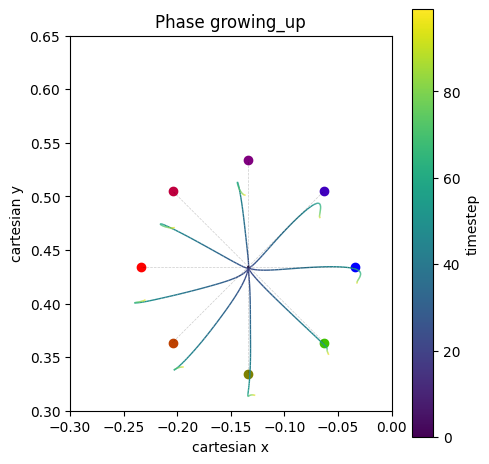

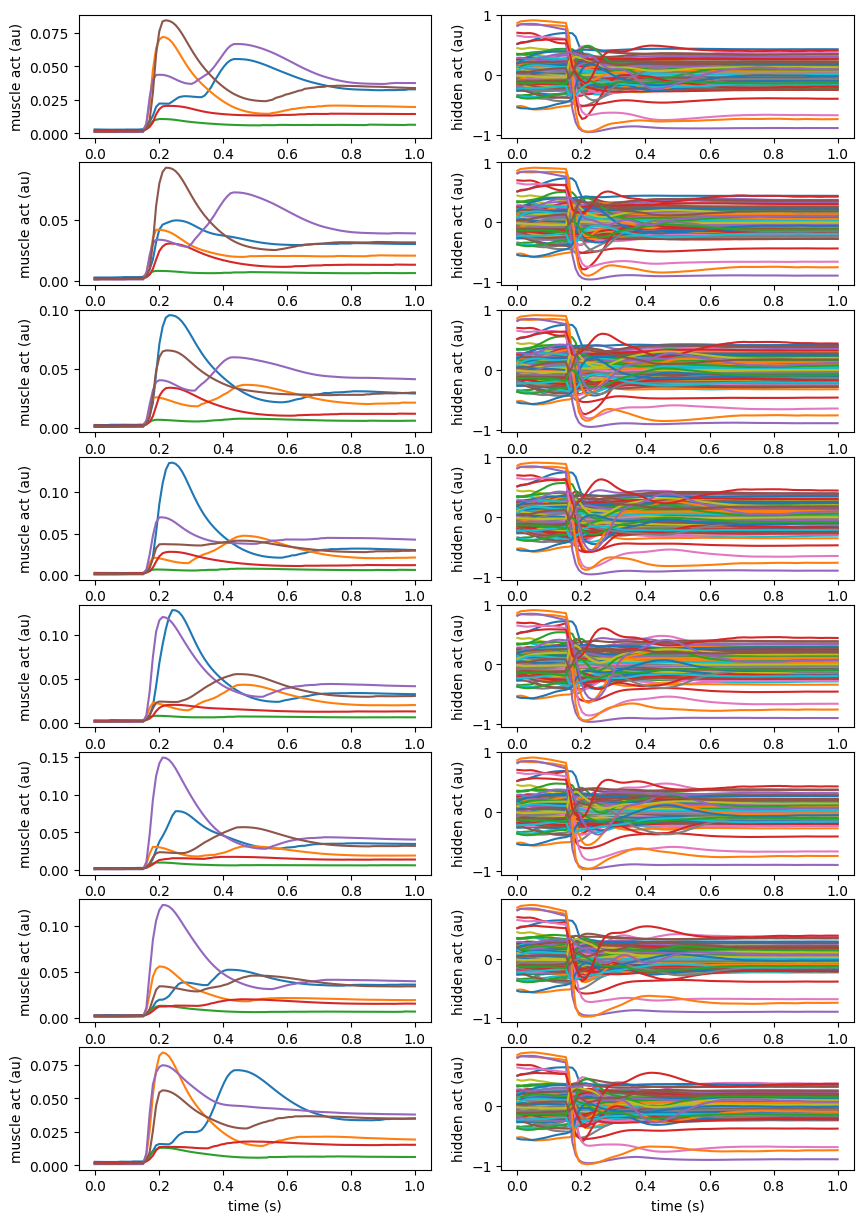

In [13]:
model_num = 7
# pert - input fix [0,11,13]
# loss0 - [2,3,7,13] 
model_name = "model{:02d}".format(model_num)
data = []
#label = ['NF1','FF1']
label = ['growing_up']
ff = [0,8]
is_channel = False
#K = 870
#B = -5
K = 170
B = -1
dT = 0.01

fig,ax = plt.subplots(1,len(label),figsize=(5*len(label),5))
if len(label) == 1:
    ax = [ax]
for i,p in enumerate(label):
    weight_file = list(Path(data_dir).glob(f'{model_name}_phase={p}_*_weights'))[0]
    cfg_file = list(Path(data_dir).glob(f'{model_name}_phase={p}_*_cfg.json'))[0]
    data.append(test(cfg_file,weight_file,ff_coefficient=ff[i],is_channel=is_channel,K=K,B=B,dT=dT,calc_endpoint_force=True,modular=modular))
    plot.plot_simulations(ax[i],xy=data[i]['xy'],target_xy=data[i]['tg'],vel=None,plot_lat=False)
    ax[i].set_title(f'Phase {p}')

plt.tight_layout()
#fig.savefig(os.path.join(data_dir,'input_flex_60000.png'),dpi=300)
plt.show()


fig, ax = plot.plot_activation(data[i]['all_hidden'],data[i]['all_muscle'],figsize=(10,15))
#fig.savefig(os.path.join(data_dir,'activation.png'),dpi=300)

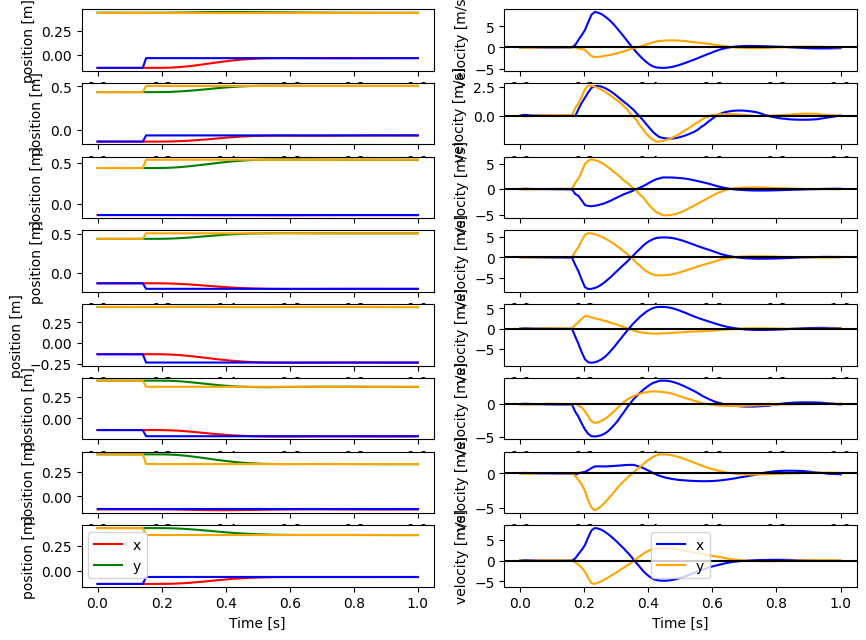

In [5]:
i = 0
fig, ax = plot.plot_kinematic(data[i]['endpoint_force'],data[i]['xy'],data[i]['tg'],figsize=(10,7.5)) # data[i]['vel']
fig.savefig(os.path.join(data_dir,'kinematic.png'),dpi=300)

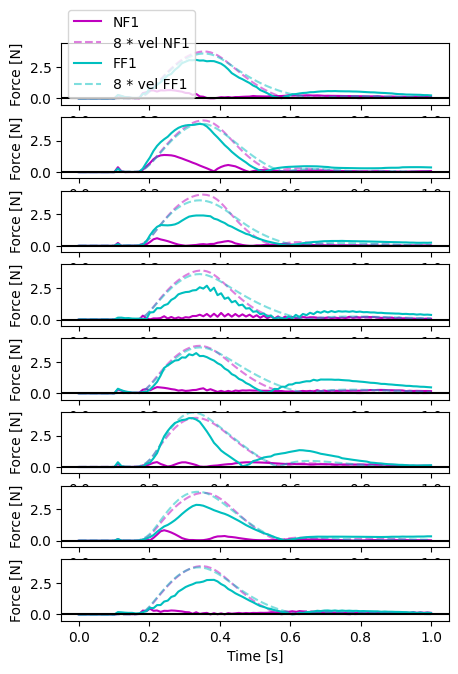

In [28]:
fig, ax = plot.plot_force(data,label,figsize=(5,7.5))
#fig.savefig(os.path.join(data_dir,'lat_force.png'),dpi=300)

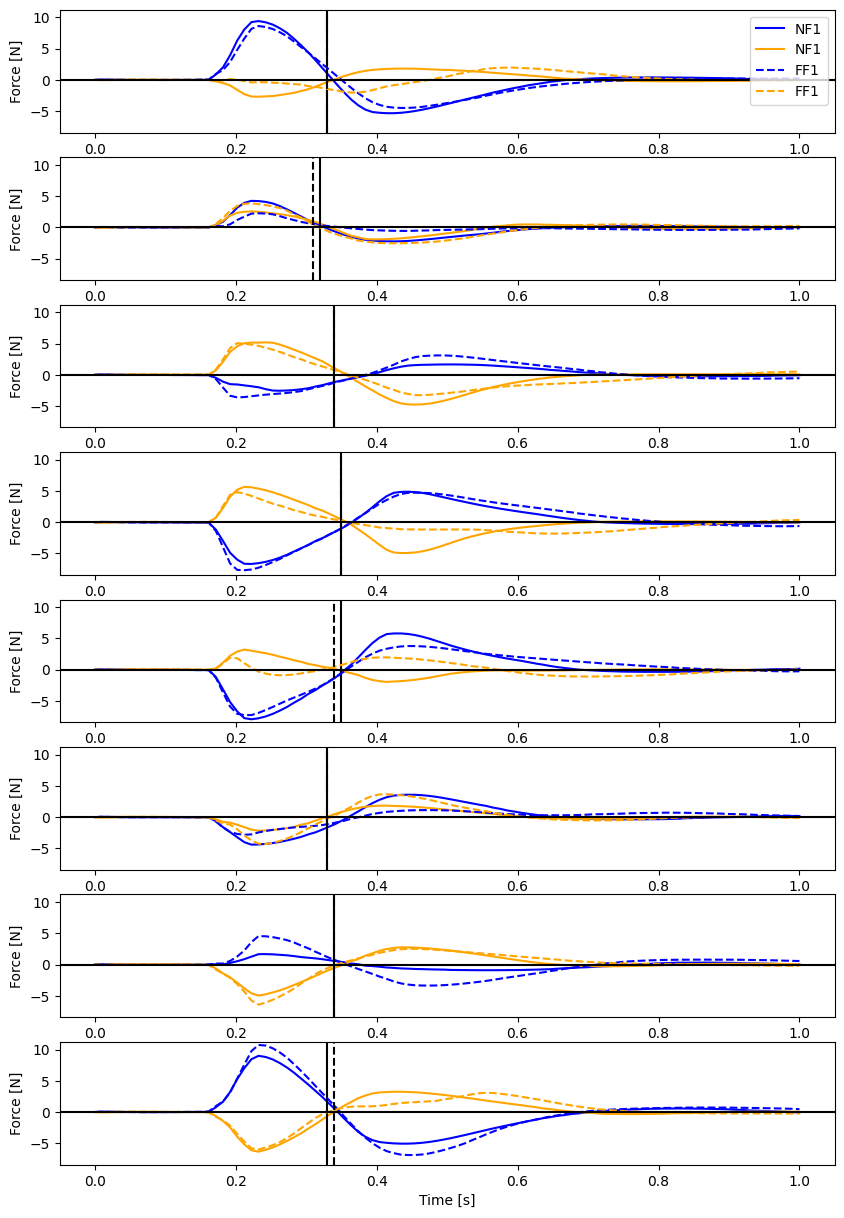

In [6]:
fg, ax = plot.plot_epforce(data,label,figsize=(10,15))